In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt

# Prediction libaries - Logistic regression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

/Users/xiamingjin/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
data = pd.read_csv('telecomdata.csv',index_col=0)

In [17]:
data.head()

,CustomerID,City,ZipCode,Gender,SeniorCitizen,Dependents,TenureMonths,PhoneService,MultipleLines,InternetService,...,PremiumTechSupport,StreamingMusic,UnlimitedData,MonthlyCharge,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,SatisfactionScore,ChurnReasonCategory
0,3668-QPYBK,Los Angeles,90003,Male,No,No,2,Yes,No,DSL,...,No,No,Yes,53.85,0.0,0,20.94,129.09,1,price
1,9237-HQITU,Los Angeles,90005,Female,No,Yes,2,Yes,No,Fiber optic,...,No,No,Yes,70.70,0.0,0,18.24,169.89,2,others
2,9305-CDSKC,Los Angeles,90006,Female,No,Yes,8,Yes,Yes,Fiber optic,...,No,Yes,Yes,99.65,0.0,0,97.20,917.70,3,others
3,7892-POOKP,Los Angeles,90010,Female,No,Yes,28,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,104.80,0.0,0,136.92,3182.97,3,others
4,0280-XJGEX,Los Angeles,90015,Male,No,Yes,49,Yes,Yes,Fiber optic,...,No,Yes,Yes,103.70,0.0,0,2172.17,7208.47,1,service


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CustomerID                     7043 non-null   object 
 1   City                           7043 non-null   object 
 2   ZipCode                        7043 non-null   int64  
 3   Gender                         7043 non-null   object 
 4   SeniorCitizen                  7043 non-null   object 
 5   Dependents                     7043 non-null   object 
 6   TenureMonths                   7043 non-null   int64  
 7   PhoneService                   7043 non-null   object 
 8   MultipleLines                  7043 non-null   object 
 9   InternetService                7043 non-null   object 
 10  OnlineSecurity                 7043 non-null   object 
 11  OnlineBackup                   7043 non-null   object 
 12  DeviceProtection               7043 non-null   o

# EDA

In [19]:
# Convert Total Charges to numerical
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')
# Fill NA churn reason with Not Churn
data['ChurnReasonCategory'] = data['ChurnReasonCategory'].fillna('Not Churn')
data['ChurnReason'] = data['ChurnReason'].fillna('Not Churn')
data.dropna(inplace = True)

Text(0.5, 1.0, 'Two Year Contract')

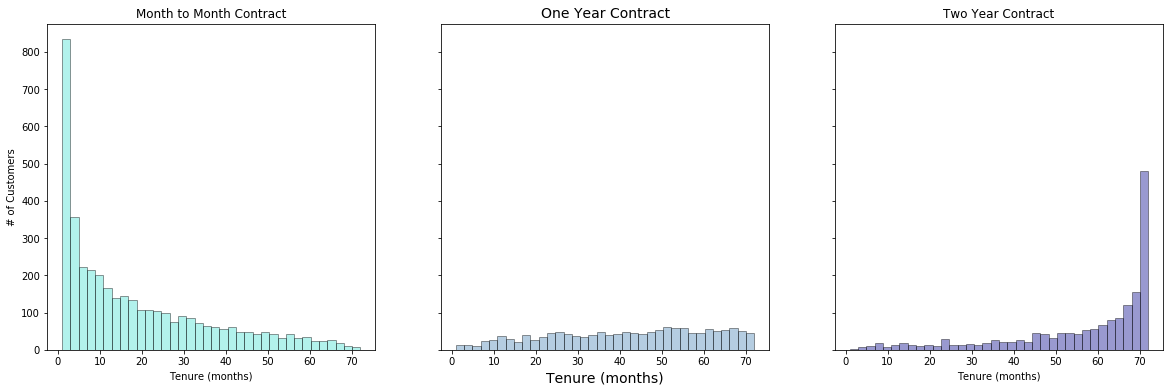

In [6]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(data[data['Contract']=='Month-to-month']['TenureMonths'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'turquoise',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')

ax = sns.distplot(data[data['Contract']=='One year']['TenureMonths'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'steelblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.distplot(data[data['Contract']=='Two year']['TenureMonths'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')

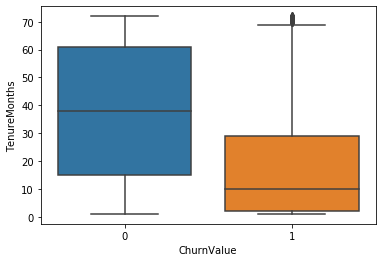

In [7]:
sns.boxplot(x = data.ChurnValue, y = data.TenureMonths)

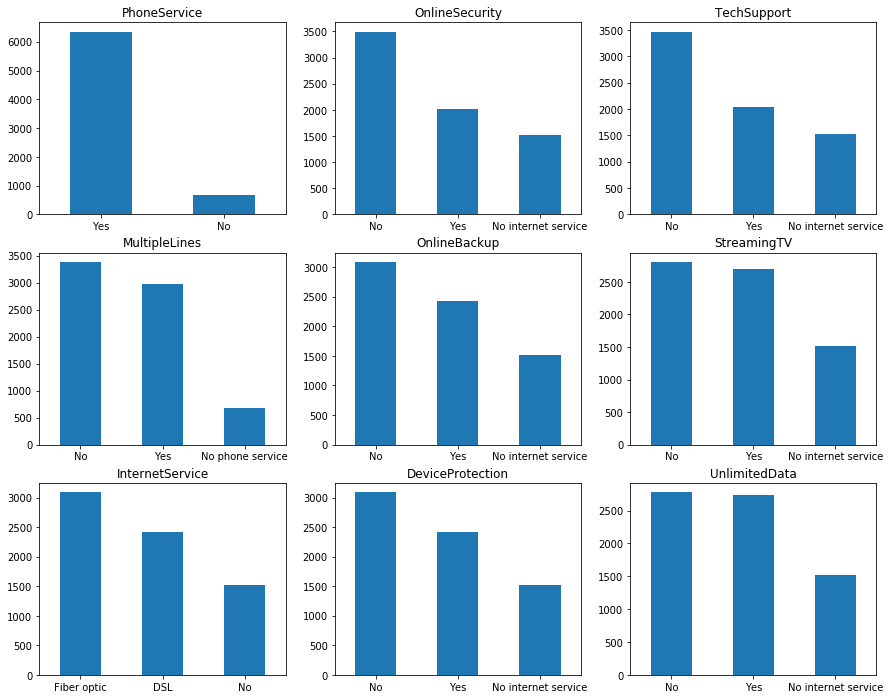

In [8]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
            'DeviceProtectionPlan', 'PremiumTechSupport', 'StreamingMusic', 'UnlimitedData']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = data[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

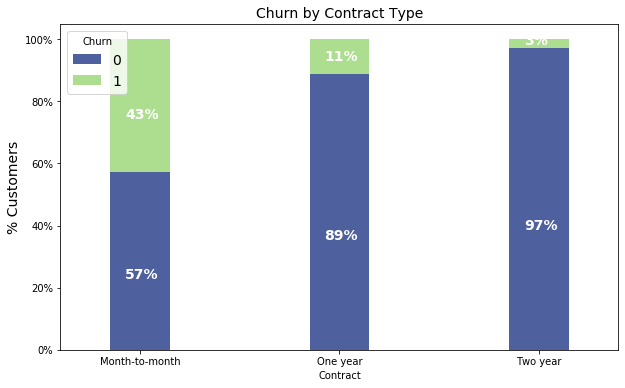

In [9]:
colors = ['#4f609e','#adde90']
contract_churn = data.groupby(['Contract','ChurnValue']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

In [10]:
data.groupby(['SatisfactionScore','ChurnValue']).size().unstack()

ChurnValue,0,1
SatisfactionScore,,
1,NaN,922.0
2,NaN,518.0
3,2233.0,429.0
4,1783.0,NaN
5,1147.0,NaN


Text(0.5, 1.0, 'Distribution of monthly charges by churn')

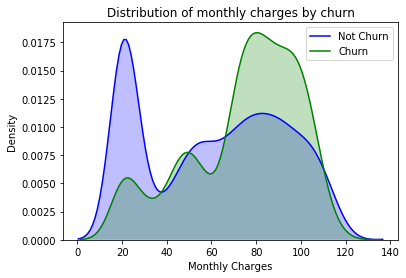

In [11]:
ax = sns.kdeplot(data.MonthlyCharges[(data["ChurnValue"] == 0) ],
                color="Blue", shade = True)
ax = sns.kdeplot(data.MonthlyCharges[(data["ChurnValue"] == 1) ],
                ax =ax, color="Green", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

Text(0.5, 1.0, 'Distribution of monthly charges by churn reason categories')

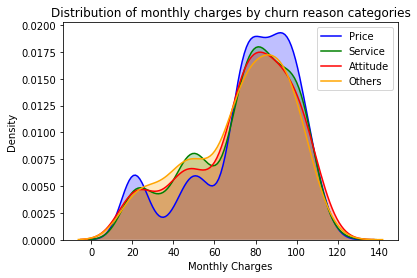

In [12]:
ax = sns.kdeplot(data.MonthlyCharges[(data["ChurnReasonCategory"] == 'price') ],
                color="Blue", shade = True)
ax = sns.kdeplot(data.MonthlyCharges[(data["ChurnReasonCategory"] == 'service') ],
                ax =ax, color="Green", shade= True)
ax = sns.kdeplot(data.MonthlyCharges[(data["ChurnReasonCategory"] == 'attitude') ],
                ax =ax, color="Red", shade= True)
ax = sns.kdeplot(data.MonthlyCharges[(data["ChurnReasonCategory"] == 'others') ],
                ax =ax, color="Orange", shade= True)
ax.legend(["Price","Service","Attitude","Others"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn reason categories')

Text(0.5, 1.0, 'Distribution of total charges by churn')

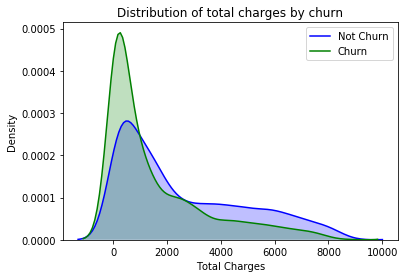

In [13]:
ax = sns.kdeplot(data.TotalCharges[(data["ChurnValue"] == 0) ],
                color="Blue", shade = True)
ax = sns.kdeplot(data.TotalCharges[(data["ChurnValue"] == 1) ],
                ax =ax, color="Green", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')

Offer plot

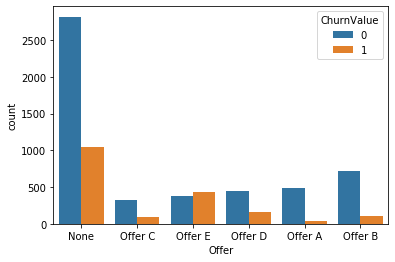

In [14]:
ax = sns.countplot(x="Offer", data=data, hue = "ChurnValue")

# Logistic Regression

In [20]:
#Remove columns related to info after knowing churn
#data.drop(columns=['ChurnReason', 'ChurnReasonCategory', 'ChurnScore', 'SatisfactionScore'],inplace = True)
data.drop(columns=['ChurnReason', 'ChurnReasonCategory', 'ChurnScore'],inplace = True)

Categorical variables

In [21]:
non_numeric_features = ['Gender', 'SeniorCitizen', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                       'PaperlessBilling', 'PaymentMethod', 'ChurnValue', 'Under30', 'Married', 'ReferredaFriend', 'Offer', 
                       'InternetType', 'DeviceProtectionPlan', 'PremiumTechSupport', 'StreamingMusic', 'UnlimitedData']

for feature in non_numeric_features:     
    # Encode target labels with value between 0 and n_classes-1
    data[feature] = LabelEncoder().fit_transform(data[feature])

In [22]:
#Remove customer IDs, city, zipcode from the data set
data = data.iloc[:,3:]

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Gender                         7032 non-null   int64  
 1   SeniorCitizen                  7032 non-null   int64  
 2   Dependents                     7032 non-null   int64  
 3   TenureMonths                   7032 non-null   int64  
 4   PhoneService                   7032 non-null   int64  
 5   MultipleLines                  7032 non-null   int64  
 6   InternetService                7032 non-null   int64  
 7   OnlineSecurity                 7032 non-null   int64  
 8   OnlineBackup                   7032 non-null   int64  
 9   DeviceProtection               7032 non-null   int64  
 10  TechSupport                    7032 non-null   int64  
 11  StreamingTV                    7032 non-null   int64  
 12  StreamingMovies                7032 non-null   i

In [24]:
cat_features = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                       'PaperlessBilling', 'PaymentMethod', 'Offer', 'InternetType']

encoded_features = []

for feature in cat_features:
    # Encode categorical features as a one-hot numeric array
    encoded_feat = OneHotEncoder().fit_transform(data[feature].values.reshape(-1, 1)).toarray()
    n = data[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = data.index
    encoded_features.append(encoded_df)
data = pd.concat([data, *encoded_features], axis=1)
    
print('Number of encoded feautes:', len(encoded_features))

# Drop columns that generated one-hot encoded variables
data2 = data.copy()
drop_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                       'PaperlessBilling', 'PaymentMethod', 'Offer', 'InternetType']
data.drop(columns=drop_cols, inplace=True)

Number of encoded feautes: 14


/Users/xiamingjin/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/xiamingjin/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "catego

In [25]:
X = data.drop(columns=['ChurnValue']).values
y = data['ChurnValue'].values

# Splitting the data
# 75% train
# 25% test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  stratify=y, random_state=22)
print('X_train shape: {}'.format(x_train.shape))
print('X_test shape: {}'.format(x_test.shape))

X_train shape: (4922, 71)
X_test shape: (2110, 71)


In [26]:
%%time

# Provides train/test indices to split data in train/test sets.
skf = StratifiedKFold(n_splits=4)
val_auc_scores = []

for train_index, valid_index in skf.split(x_train, y_train):
    x_pseudo_train, x_pseudo_valid = x_train[train_index], x_train[valid_index]
    y_pseudo_train, y_pseudo_valid = y_train[train_index], y_train[valid_index]
    # Standardize features by removing the mean and scaling to unit variance
    ss = StandardScaler()
    # Fit to data, then transform it.
    x_pseudo_train_scaled = ss.fit_transform(x_pseudo_train)
    # Perform standardization by centering and scaling
    x_pseudo_valid_scaled = ss.transform(x_pseudo_valid)
    # Logistic Regression
    lr = LogisticRegression() # Using default parameters
    # Fit the model according to the given training data
    lr.fit(x_pseudo_train_scaled, y_pseudo_train)
    # Predict logarithm of probability estimates.
    y_pred_valid_probs = lr.predict_proba(x_pseudo_valid_scaled)[:, 1]
    # Compute Receiver operating characteristic (ROC)
    val_fpr, val_tpr, val_thresholds = roc_curve(y_pseudo_valid, y_pred_valid_probs)
    # Compute Area Under the Curve (AUC) using the trapezoidal rule
    val_auc_score = auc(val_fpr, val_tpr)
    val_auc_scores.append(val_auc_score)

/Users/xiamingjin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/xiamingjin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/xiamingjin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 1.77 s, sys: 48.8 ms, total: 1.82 s
Wall time: 685 ms


/Users/xiamingjin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [27]:
# Standardize features by removing the mean and scaling to unit variance
ss = StandardScaler()
# Fit to data, then transform it.
x_train_scaled = ss.fit_transform(x_train)
# Perform standardization by centering and scaling
x_test_scaled = ss.transform(x_test)

# Applying logistic regression classifier
lr = LogisticRegression()        # Using default parameters
lr.fit(x_train_scaled, y_train)  # Training the model with X_train, y_train

# Generate Confusion Matrix
y_pred = lr.predict(x_test_scaled)
y_pred = pd.Series(y_pred)
y_test = pd.Series(y_test)
pd.crosstab(y_pred, y_test, rownames=['Predicted'], colnames=['True'], margins=True)

/Users/xiamingjin/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


True,0,1,All
Predicted,,,
0,1517,58,1575
1,32,503,535
All,1549,561,2110


In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1549
           1       0.94      0.90      0.92       561

    accuracy                           0.96      2110
   macro avg       0.95      0.94      0.94      2110
weighted avg       0.96      0.96      0.96      2110



# OCT tree performance

In [9]:
oct_df = pd.read_csv('oct_1_10.csv',index_col=0)

In [10]:
#x1: y_test, x1_1: y_pred
oct_df

,SeniorCitizen,Dependents,MonthlyCharges,TotalCharges,CLTV,Age,Under30,Married,NumberofDependents,ReferredaFriend,...,Offer_3,Offer_4,Offer_5,Offer_6,InternetType_1,InternetType_2,InternetType_3,InternetType_4,x1,x1_1
Gender,,,,,,,,,,,,,,,,,,,,,
1,0,1,103.70,5036.30,5340,38,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,2
1,1,0,39.65,39.65,5433,78,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,10
1,0,1,69.70,316.90,2454,56,0,0,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,4
0,0,1,75.15,496.90,3457,34,0,1,5,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,4
0,0,1,78.95,927.35,5806,34,0,0,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,1,0,63.10,4685.55,4933,78,0,1,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,6
0,0,0,20.65,1020.75,4725,25,1,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,7
1,0,0,73.35,931.55,4645,64,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10,10


In [11]:
oct_df['x1_1'].unique()

array([ 2, 10,  4,  1,  3,  8,  0,  7,  6,  9])

In [12]:
oct_df['y_pred'] = oct_df['x1_1'].apply(lambda x: 1 if x < 5 else 0)
oct_df['y_test'] = oct_df['x1'].apply(lambda x: 1 if x < 5 else 0)

In [13]:
y_test_oct = oct_df['y_test']
y_pred_oct = oct_df['y_pred']

In [14]:
pd.crosstab(y_pred_oct, y_test_oct, rownames=['Predicted'], colnames=['True'], margins=True)

True,0,1,All
Predicted,,,
0,1517,94,1611
1,35,467,502
All,1552,561,2113


In [15]:
print(classification_report(y_test_oct,y_pred_oct))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1552
           1       0.93      0.83      0.88       561

    accuracy                           0.94      2113
   macro avg       0.94      0.90      0.92      2113
weighted avg       0.94      0.94      0.94      2113



In [31]:
sat3 = oct_df[oct_df['SatisfactionScore']==3]

In [38]:
sat3.groupby('x1').count()

,SeniorCitizen,Dependents,MonthlyCharges,TotalCharges,CLTV,Age,Under30,Married,NumberofDependents,ReferredaFriend,...,Offer_4,Offer_5,Offer_6,InternetType_1,InternetType_2,InternetType_3,InternetType_4,x1_1,y_pred,y_test
x1,,,,,,,,,,,,,,,,,,,,,
0,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
1,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
2,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
3,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
4,72,72,72,72,72,72,72,72,72,72,...,72,72,72,72,72,72,72,72,72,72
6,155,155,155,155,155,155,155,155,155,155,...,155,155,155,155,155,155,155,155,155,155
7,102,102,102,102,102,102,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102
8,173,173,173,173,173,173,173,173,173,173,...,173,173,173,173,173,173,173,173,173,173
9,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43
